JITコンパイル中...（初回のみ時間がかかります）
最適化を開始します...


100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


最適化完了 (100ステップ, 240.238 秒)

最終的な最適デバイス長: 2411.7 um
その時のSHG変換効率: 75.1048%


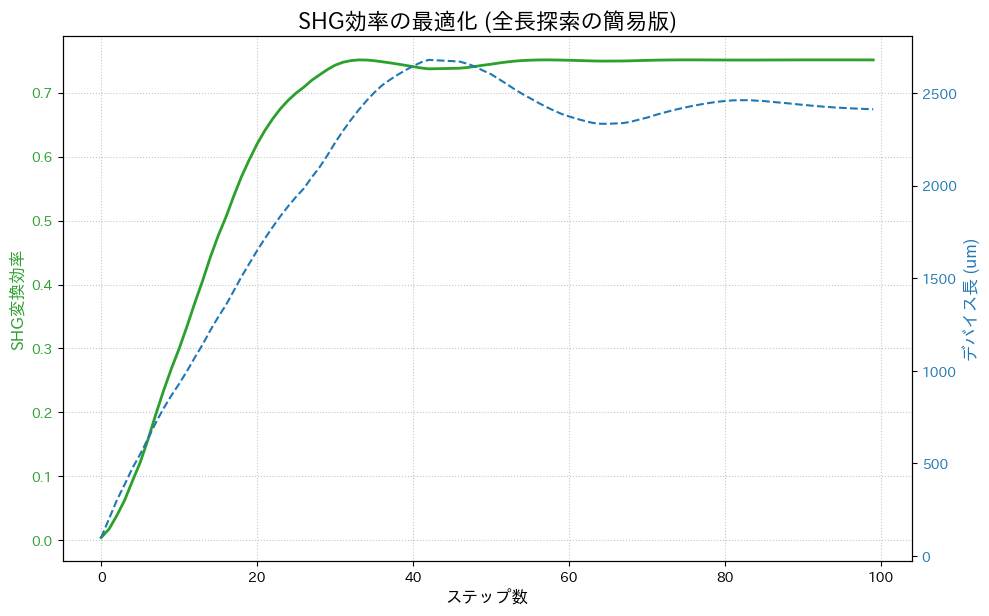

In [ ]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import time

from qpm import mgoslt, cwes

Z_MAX = 10000.0  # 考慮する最大デバイス長 (um)
KAPPA_MAG = jnp.arctanh(jnp.sqrt(0.95)) / 2000 * 2 / jnp.pi
DESIGN_TEMP_C = 70.0
DESIGN_WAVELENGTH = 1.031

DELTA_K_SHG = mgoslt.calc_twm_delta_k(
    DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C)
DELTA_K_SHG = mgoslt.calc_twm_delta_k(
    DESIGN_WAVELENGTH, DESIGN_WAVELENGTH / 2.0, DESIGN_TEMP_C)
DOMAIN_LEN_SHG = jnp.pi / DELTA_K_SHG
MAX_TOTAL_DOMAINS = int(jnp.ceil(Z_MAX / DOMAIN_LEN_SHG))
DOMAIN_INDICES = jnp.arange(MAX_TOTAL_DOMAINS)
ALTERNATING_SIGN = jnp.power(-1.0, DOMAIN_INDICES)
B_INITIAL = jnp.array([jnp.sqrt(0.5), jnp.sqrt(0.5), 0.0], dtype=jnp.complex64)


def loss_and_aux_fn(total_length_param: jnp.ndarray):
    total_length = total_length_param[0]

    num_active_domains = total_length / DOMAIN_LEN_SHG

    steepness = 10.0
    active_mask = jax.nn.sigmoid(
        steepness * (num_active_domains - DOMAIN_INDICES))

    h_total = DOMAIN_LEN_SHG * active_mask
    kappa_total = KAPPA_MAG * ALTERNATING_SIGN * active_mask
    superlattice = jnp.stack([h_total, kappa_total], axis=1)

    B_final = cwes.simulate_twm(
        superlattice, DELTA_K_SHG, DELTA_K_SHG, B_INITIAL)

    sfg_efficiency = jnp.abs(B_final[2])**2
    loss = -sfg_efficiency

    return loss, (sfg_efficiency, total_length)


def run_optimization():
    learning_rate = 100.0
    num_steps = 100
    optimizer = optax.adam(learning_rate)

    initial_params = jnp.array([100.0])
    opt_state = optimizer.init(initial_params)
    params = initial_params

    value_and_grad_fn = jax.value_and_grad(loss_and_aux_fn, has_aux=True)

    @jax.jit
    def optimization_step(params, opt_state):
        (loss, aux_data), grads = value_and_grad_fn(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss, aux_data

    history = {"shg_eff": [], "length": []}

    print("JITコンパイル中...（初回のみ時間がかかります）")
    optimization_step(params, opt_state)
    print("最適化を開始します...")

    start_time = time.perf_counter()
    for _ in tqdm(range(num_steps)):
        params, opt_state, loss, (shg_eff, current_length) = optimization_step(
            params, opt_state)

        history["shg_eff"].append(shg_eff)
        history["length"].append(current_length)

    jax.block_until_ready(history)
    end_time = time.perf_counter()
    print(f"最適化完了 ({num_steps}ステップ, {end_time - start_time:.3f} 秒)")

    final_length = history["length"][-1]
    final_shg_eff = history["shg_eff"][-1]

    print(f"\n最終的な最適デバイス長: {final_length:.1f} um")
    print(f"その時のSHG変換効率: {final_shg_eff:.4%}")

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:green'
    ax1.set_xlabel("ステップ数", fontsize=12)
    ax1.set_ylabel("SHG変換効率", fontsize=12, color=color)
    ax1.plot(jnp.array(history["shg_eff"]), color=color, lw=2, label='SHG効率')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle=':', alpha=0.7)

    # 長さのプロット (右のY軸)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel("デバイス長 (um)", fontsize=12, color=color)
    ax2.plot(jnp.array(history["length"]),
             color=color, linestyle='--', label='デバイス長')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("SHG効率の最適化 (全長探索の簡易版)", fontsize=16)
    plt.show()


if __name__ == '__main__':
    run_optimization()